In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [159]:
all_centroid_over_time = np.load('all_centroid_over_time.npz')['arr_0']
green_centroid_over_time = np.load('green_centroid_over_time.npz')['arr_0']
red_centroid_over_time = np.load('red_centroid_over_time.npz')['arr_0']
body_centroid_over_time = np.load('body_centroid_over_time.npz')['arr_0']

In [3]:
video = cv2.VideoCapture('../Raw-Data/vx1_JZ1/raw/20161121/20161121_JZ1_02.1.mp4')
frame_size = (int(video.get(3)), int(video.get(4)))
frame_rate = video.get(5)
n_frames = int(video.get(7))
is_grabbed, frame = video.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
video.release()

36464
36599


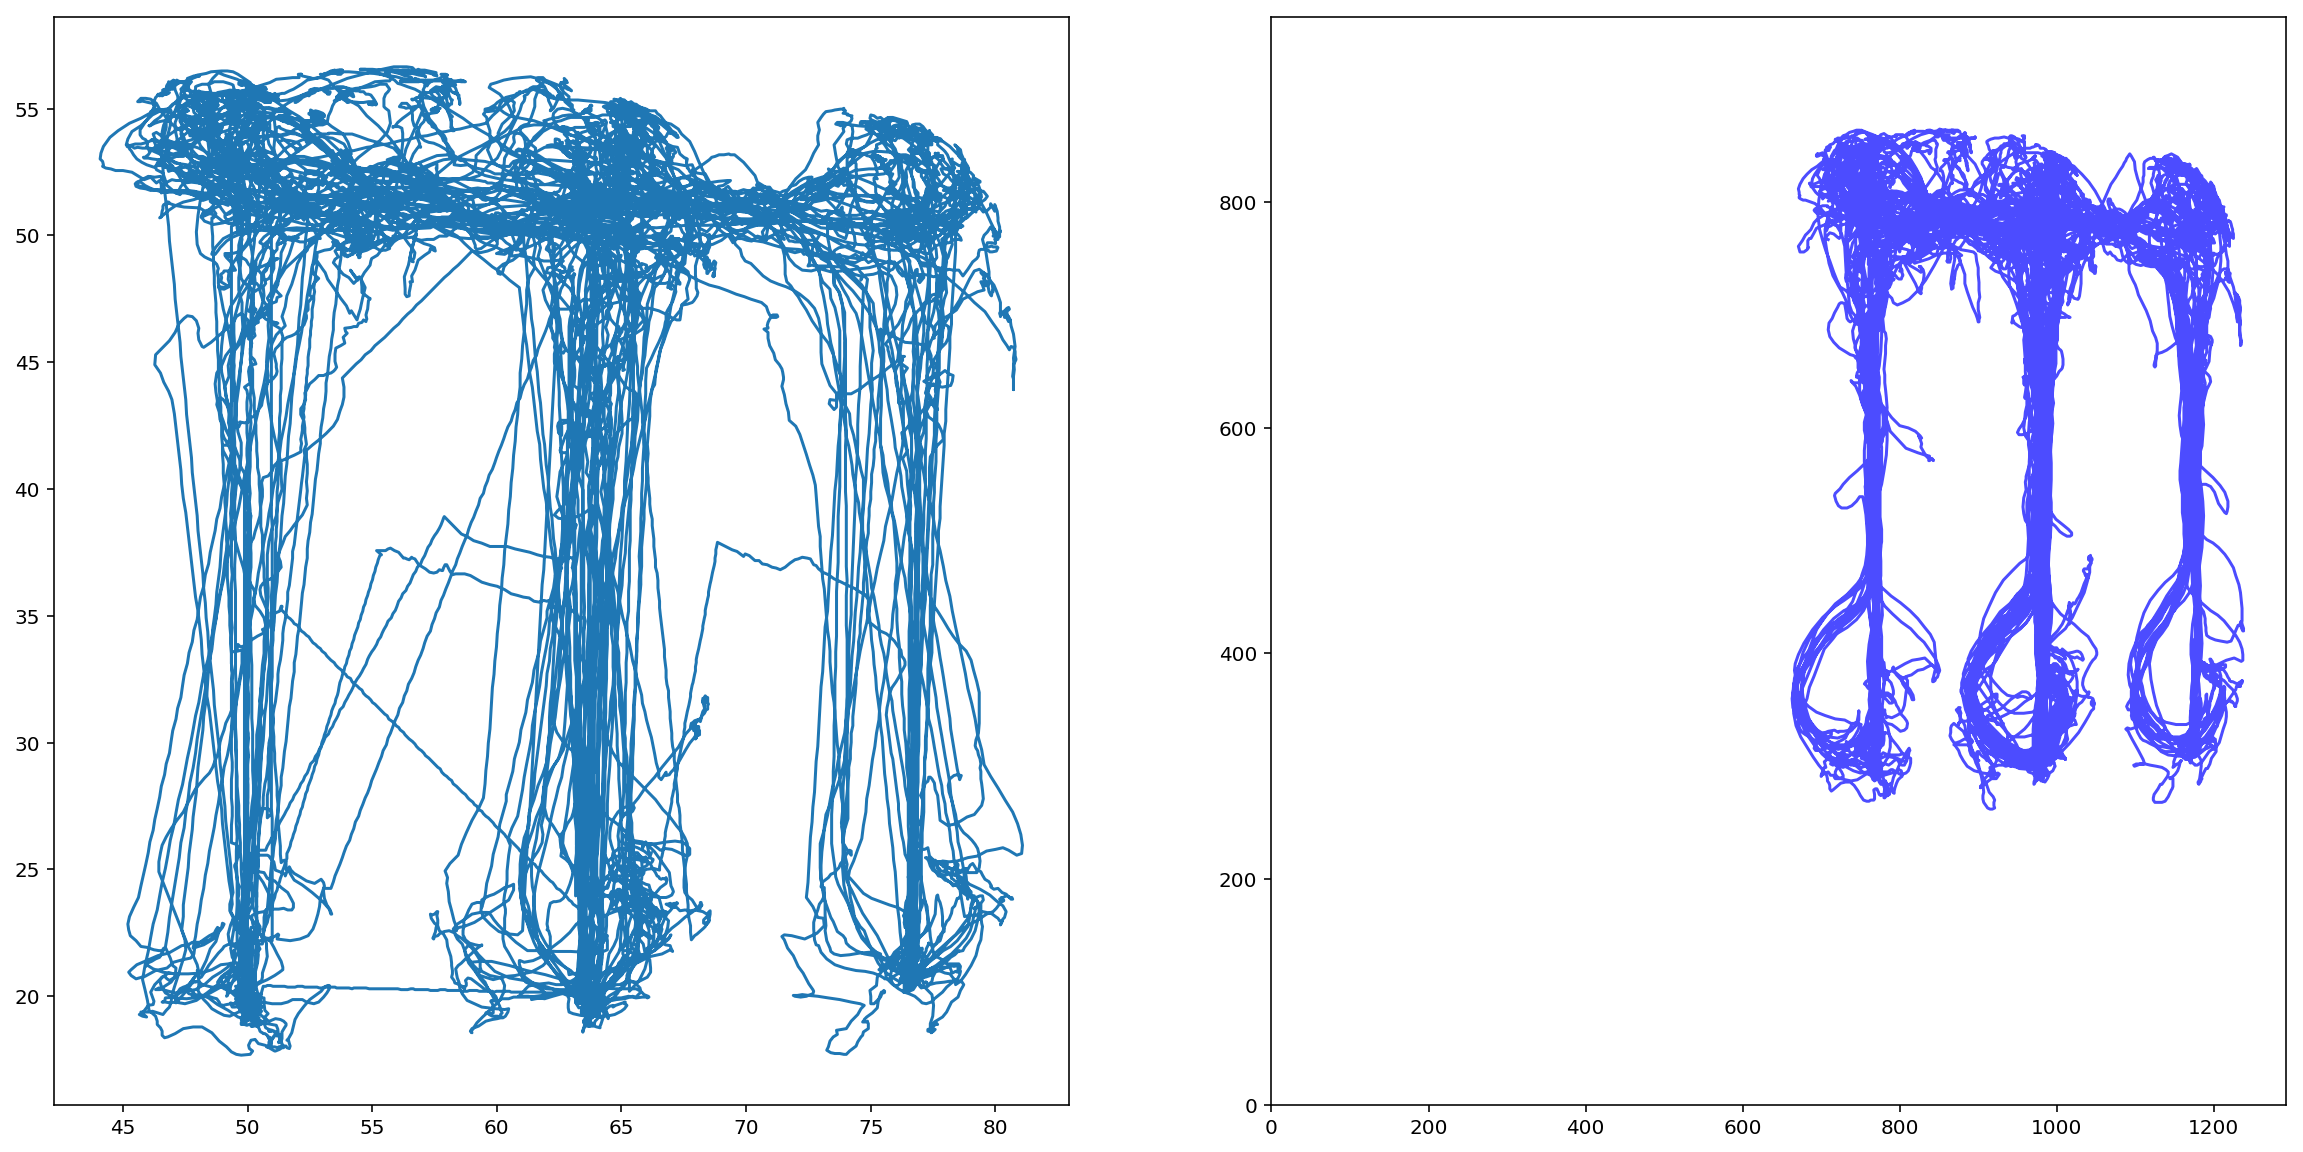

In [6]:
from loren_frank_data_processing import get_position_dataframe
from src.parameters import ANIMALS

epoch_key = ('JZ1', 7, 2)
position_info = get_position_dataframe(epoch_key, ANIMALS)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].plot(position_info.x_position, position_info.y_position);

ALPHA = 0.7
axes[1].plot(all_centroid_over_time[:, 0], frame_size[1] - all_centroid_over_time[:, 1], color='blue', alpha=ALPHA);
axes[1].set_xlim((0, frame_size[0]))
axes[1].set_ylim((0, frame_size[1]));

print(body_centroid_over_time.shape[0])
print(position_info.shape[0])

In [310]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import scipy.linalg


zs = red_centroid_over_time[:300]
dt = 1 / 29
q = Q_discrete_white_noise(dim=3, dt=dt, var=1)
Q = scipy.linalg.block_diag(q, q)

v = dt
a = 0.5 * dt**2
f = np.array([[1, v, a,],
              [0, 1, 0],
              [0, 0, 1]])
F = scipy.linalg.block_diag(f, f)
F

h = np.array([1, 0, 0])
H = scipy.linalg.block_diag(h, h)

# Observation covariance
R = np.diag([1, 1]) * 1E-5

init_x = np.array([[zs[0, 0], 0, 0, zs[0, 1], 0, 0]]).T
init_P = np.diag([1, 500, 500, 1, 500, 500])


kalman = KalmanFilter(dim_x=6, dim_z=2)

kalman.x_prior = init_x   # state (x and dx)
kalman.P_prior = init_P   # covariance matrix

kalman.F = F    # state transition
kalman.H = H    # Measurement function

kalman.R = R    # state uncertainty
kalman.Q = Q    # process uncertainty

In [104]:
def kalman_filter2(data, state_transition, state_to_observed,
                   state_covariance, measurement_covariance,
                   prior_state, prior_covariance):
    '''Handles missing observations
    
    Parameters
    ----------
    data : ndarray, shape (n_time, n_observables)
        Observations from sensors
    state_transition : ndarray, shape (n_states, n_states)
        State transition matrix, F
    state_to_observed : ndarray, shape (n_observables, n_states)
        Measurement function/Observation Model, H
    state_covariance : ndarray, shape (n_states, n_states)
        Process covariance, Q
    measurement_covariance : ndarray, shape (n_observables, n_observables)
        Observation covariance, R
    prior_state : ndarray, shape (n_states,)
        Initial state mean
    prior_covariance : ndarray, shape (n_states, n_states)
        Initial state covariance (belief in state)
    
    Returns
    -------
    posterior_mean : ndarray (n_time, n_states)
    posterior_covariance : ndarray (n_time, n_states, n_states)
    
    '''
    n_time, n_states = data.shape[0], state_transition.shape[0]
    posterior_mean = np.zeros((n_time, n_states))
    posterior_covariance = np.zeros((n_time, n_states, n_states))
    
    posterior_mean[0] = prior_state.copy()
    posterior_covariance[0] = prior_covariance.copy()
    
    I = np.eye(n_states)
    
    for time_ind in np.arange(1, n_time):
        # Predict
        prior_mean = state_transition @ posterior_mean[time_ind - 1]
        prior_covariance = (
            state_transition @ posterior_covariance[time_ind - 1] @ state_transition.T
            + state_covariance)
        
        # Update
        system_uncertainty = (
            state_to_observed @ prior_covariance @ state_to_observed.T
            + measurement_covariance)
        
        # kalman gain (n_states, n_observables), prediction uncertainty vs. measurement uncertainty
        kalman_gain = prior_covariance @ state_to_observed.T @ np.linalg.pinv(system_uncertainty)
        prediction_error = data[time_ind] - state_to_observed @ prior_mean # innovation
        
        # Handle missing data by not updating the estimate and covariance
        is_missing = np.isnan(data[time_ind])
        prediction_error[is_missing] = 0.0
        kalman_gain[:, is_missing] = 0.0
        
        # Update mean
        posterior_mean[time_ind] = prior_mean + kalman_gain @ prediction_error
        
        # Update covariance
        I_KH = I - kalman_gain @ state_to_observed
        posterior_covariance[time_ind] = (
            I_KH @ prior_covariance @ I_KH.T +
            kalman_gain @ measurement_covariance @ kalman_gain.T)

    
    return posterior_mean, posterior_covariance


def rts_smoother(posterior_mean, posterior_covariance, state_transition, state_covariance):
    """
    Runs the Rauch-Tung-Striebal Kalman smoother on a set of
    means and covariances computed by a Kalman filter. The usual input
    would come from the output of `KalmanFilter.batch_filter()`.
    Parameters
    ----------
    Xs : numpy.array
       array of the means (state variable x) of the output of a Kalman
       filter.
    Ps : numpy.array
        array of the covariances of the output of a kalman filter.
    Fs : list-like collection of numpy.array, optional
        State transition matrix of the Kalman filter at each time step.
        Optional, if not provided the filter's self.F will be used
    Qs : list-like collection of numpy.array, optional
        Process noise of the Kalman filter at each time step. Optional,
        if not provided the filter's self.Q will be used
    inv : function, default numpy.linalg.inv
        If you prefer another inverse function, such as the Moore-Penrose
        pseudo inverse, set it to that instead: kf.inv = np.linalg.pinv
    Returns
    -------
    x : numpy.ndarray
       smoothed means
    P : numpy.ndarray
       smoothed state covariances
    K : numpy.ndarray
        smoother gain at each step
    Pp : numpy.ndarray
       Predicted state covariances
    Examples
    --------
    .. code-block:: Python
        zs = [t + random.randn()*4 for t in range (40)]
        (mu, cov, _, _) = kalman.batch_filter(zs)
        (x, P, K, Pp) = rts_smoother(mu, cov, kf.F, kf.Q)
    """
    n_time, n_states = posterior_mean.shape
    smoothed_mean, smoothed_covariances = posterior_mean.copy(), posterior_covariance.copy()
    
    for time_ind in np.arange(n_time - 2, -1, -1):
        prior_covariance = (
            state_transition @ posterior_covariance[time_ind] @ state_transition.T +
            state_covariance)
        smoother_gain = posterior_covariance[time_ind] @ state_transition.T @ np.linalg.pinv(prior_covariance)
        smoothed_mean[time_ind] += smoother_gain @ (smoothed_mean[time_ind + 1] - state_transition @ smoothed_mean[time_ind])
        smoothed_covariances[time_ind] += smoother_gain @ (smoothed_covariances[time_ind + 1] - prior_covariance) @ smoother_gain.T
        
    return smoothed_mean, smoothed_covariances


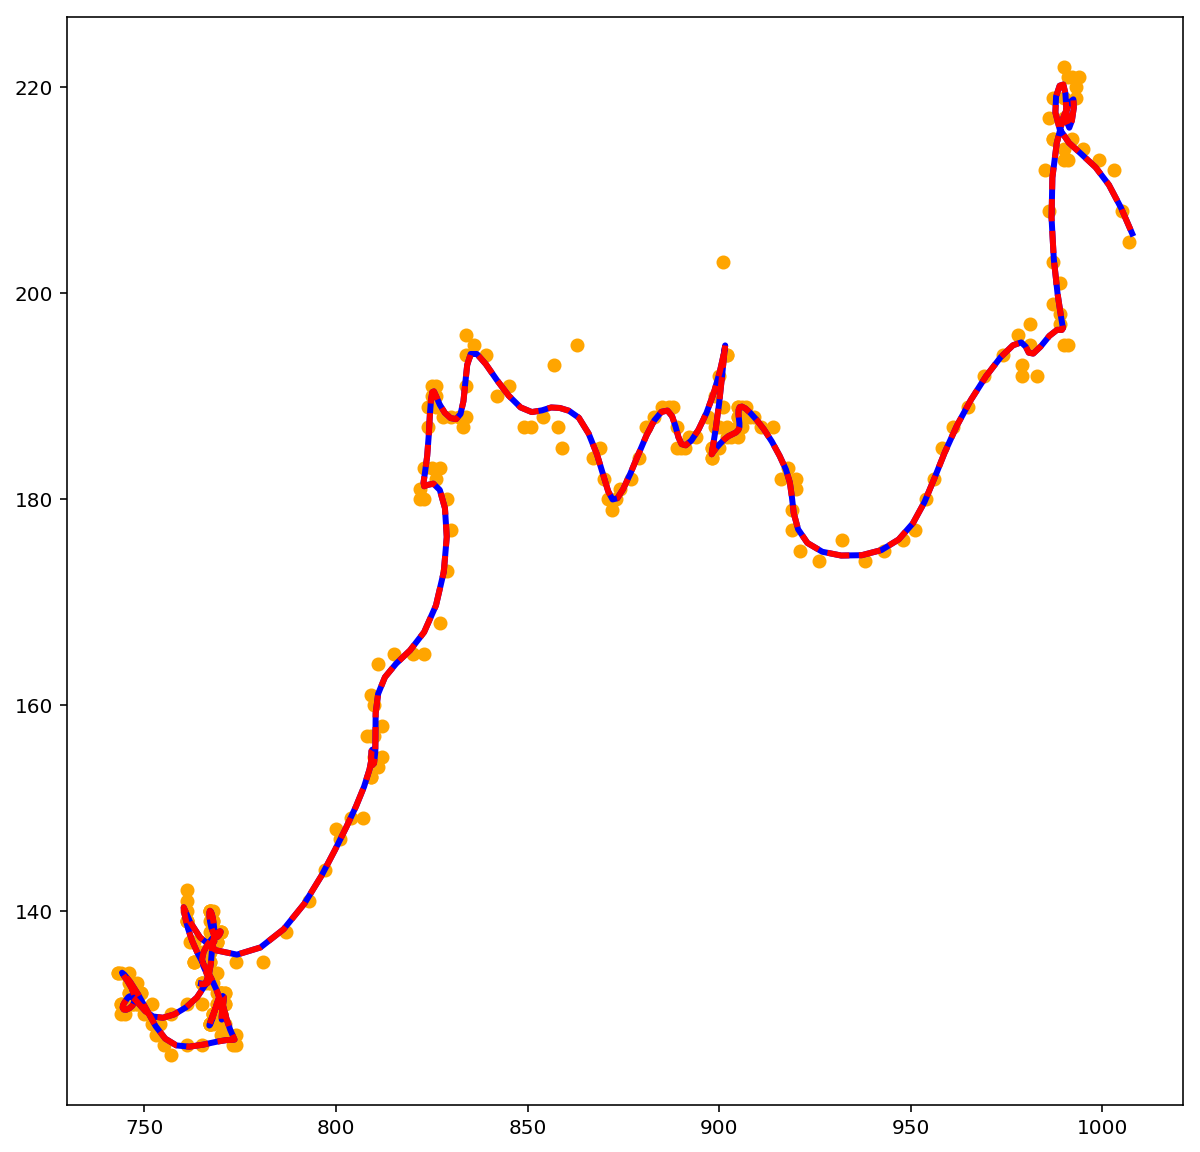

In [164]:
# filter data with Kalman filter, than run smoother on it
mu, cov, _, _ = kalman.batch_filter(zs)
M, P, C, _ = kalman.rts_smoother(mu, cov)

xs, cov = kalman_filter2(zs, F, H, Q, R, init_x.squeeze(), init_P)
xs, cov = rts_smoother(xs, cov, F, Q)


plt.figure(figsize=(10, 10))
plt.scatter(zs[:, 0], zs[:, 1], color='orange')
plt.plot(M[:, 0], M[:, 3], color='blue', linewidth=3);
plt.plot(xs[:, 0], xs[:, 3], color='red', linewidth=3, linestyle='--');

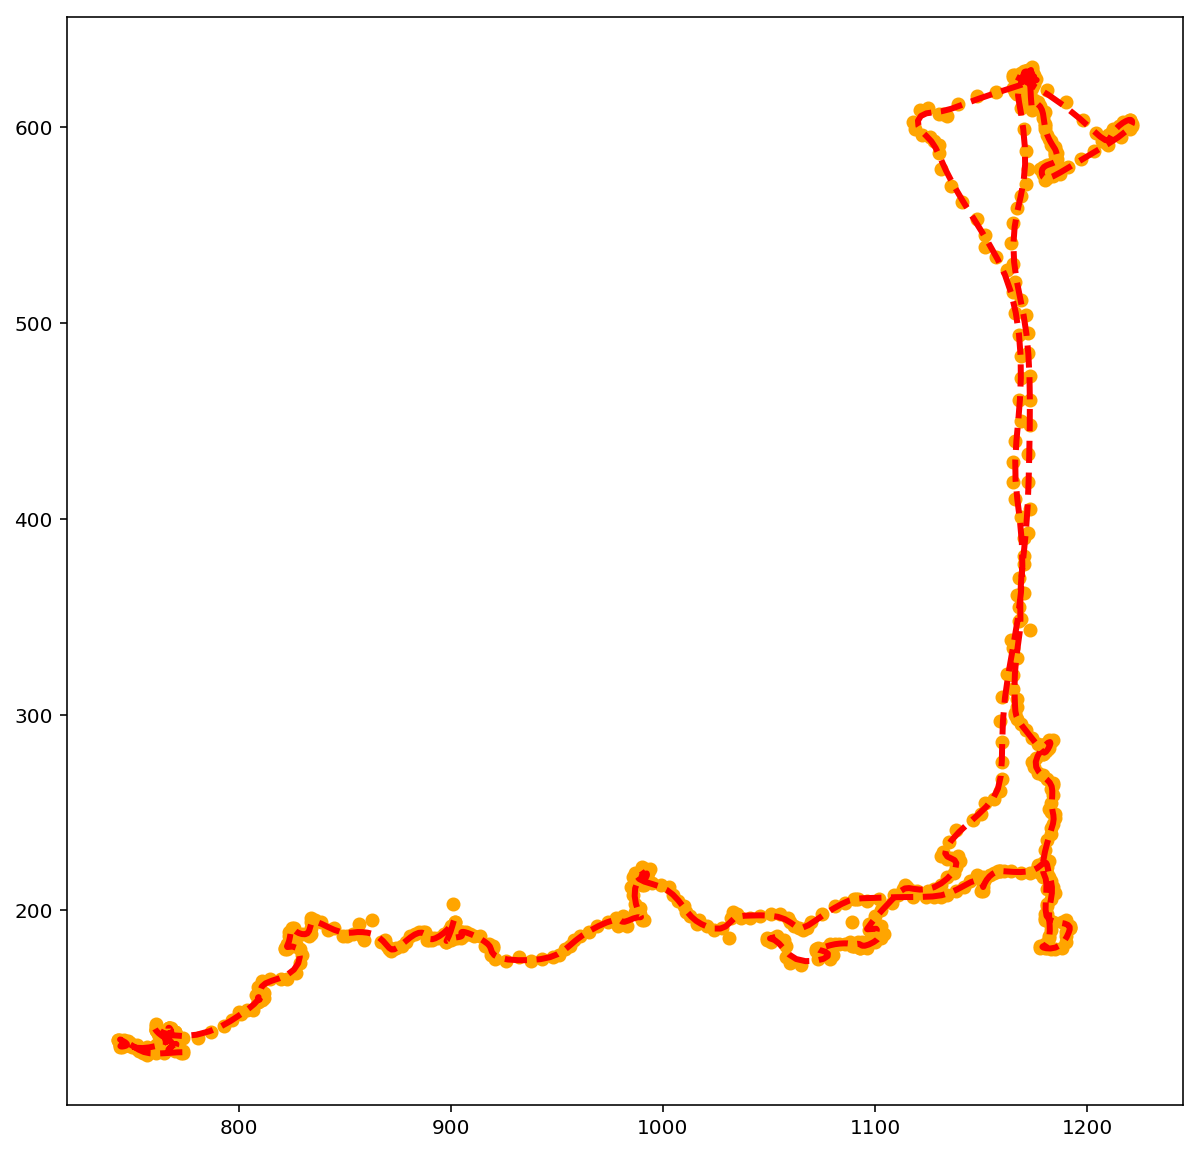

In [165]:
# filter data with Kalman filter, than run smoother on it
zs = red_centroid_over_time[:800].copy()
mu, cov, _, _ = kalman.batch_filter(zs)
M, P, C, _ = kalman.rts_smoother(mu, cov)

xs, cov = kalman_filter2(zs, F, H, Q, R, init_x.squeeze(), init_P)
xs, cov = rts_smoother(xs, cov, F, Q)

plt.figure(figsize=(10, 10))
plt.scatter(zs[:, 0], zs[:, 1], color='orange')
plt.plot(M[:, 0], M[:, 3], color='blue', linewidth=3);
plt.plot(xs[:, 0], xs[:, 3], color='red', linewidth=3, linestyle='--');

In [311]:
# filter data with Kalman filter, than run smoother on it
zs = red_centroid_over_time[:5000].copy()
mu, cov, _, _ = kalman.batch_filter(zs)
M, P, C, _ = kalman.rts_smoother(mu, cov)

xs, cov = kalman_filter2(zs, F, H, Q, R, init_x.squeeze(), init_P)
xs, cov = rts_smoother(xs, cov, F, Q)

plt.figure(figsize=(10, 10))
plt.scatter(zs[:, 0], zs[:, 1], color='orange')
plt.plot(M[:, 0], M[:, 3], color='blue', linewidth=3);
plt.plot(xs[:, 0], xs[:, 3], color='red', linewidth=3, linestyle='--');

ValueError: could not broadcast input array from shape (12,12) into shape (6,6)

In [167]:
from tqdm import tqdm_notebook as tqdm

RGB_PINK = (255, 192, 203)
RGB_YELLOW = (255, 255, 0)

video = cv2.VideoCapture('../Raw-Data/vx1_JZ1/raw/20161121/20161121_JZ1_02.1.mp4')
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
frame_size = (int(video.get(3)), int(video.get(4)))
frame_rate = video.get(5)
# n_frames = int(video.get(7))
n_frames = xs.shape[0]
out = cv2.VideoWriter('output_kalman.avi', fourcc, frame_rate, frame_size, True)

for time_ind in tqdm(range(n_frames - 1)):
    is_grabbed, frame = video.read() 
    if is_grabbed: 
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        original_position = red_centroid_over_time[time_ind].copy()
#         original_position[0] = frame_size[0] - original_position[0]
        original_position[1] = frame_size[1] - original_position[1]
        
        kalman_position = xs[time_ind, [0, 3]]
        kalman_position[1] = frame_size[1] - kalman_position[1]
        
        if np.all(~np.isnan(original_position)):
            cv2.circle(frame, tuple(original_position.astype(int)), 8, RGB_YELLOW, -1, cv2.CV_8U)
        cv2.circle(frame, tuple(kalman_position.astype(int)), 8, RGB_PINK, -1, cv2.CV_8U)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame)
    else:
        break
        

video.release()
out.release()
cv2.destroyAllWindows()

In [367]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import scipy.linalg

n_time = 300

zs = np.concatenate((red_centroid_over_time[:n_time], green_centroid_over_time[:n_time]), axis=1)
dt = 1 / frame_rate
q = Q_discrete_white_noise(dim=3, dt=dt, var=1)
Q = scipy.linalg.block_diag(q, q, q, q)

v = dt
a = 0.5 * dt**2
f = np.array([[1, v, a,],
              [0, 1, 0],
              [0, 0, 1]])
F = scipy.linalg.block_diag(f, f, f, f)
F

h = np.array([1, 0, 0])
H = scipy.linalg.block_diag(h, h, h, h)

# Observation covariance
R = np.diag([1, 1, 1, 1]) * 1E-4

init_x = np.array([[zs[0, 0], 0, 0, zs[0, 1], 0, 0, zs[0, 2], 0, 0, zs[0, 3], 0, 0]]).T
# init_P = np.diag([1, 500, 500, 1, 500, 500, 1, 500, 500, 1, 500, 500])
p = np.diag([1, 1, 1])
init_P = scipy.linalg.block_diag(p, p, p, p)

for ind1, ind2 in zip(range(6), range(6, 12)):
    init_P[ind1, ind2] = init_P[ind1, ind1]
    init_P[ind2, ind1] = init_P[ind1, ind1]

kalman = KalmanFilter(dim_x=12, dim_z=4)

kalman.x_prior = init_x   # state (x and dx)
kalman.P_prior = init_P   # covariance matrix

kalman.F = F    # state transition
kalman.H = H    # Measurement function

kalman.R = R    # state uncertainty
kalman.Q = Q    # process uncertainty

In [368]:
# filter data with Kalman filter, than run smoother on it
mu, cov, _, _ = kalman.batch_filter(zs)
M, P, C, _ = kalman.rts_smoother(mu, cov)

xs, cov = kalman_filter2(zs, F, H, Q, R, init_x.squeeze(), init_P)
xs, cov = rts_smoother(xs, cov, F, Q)

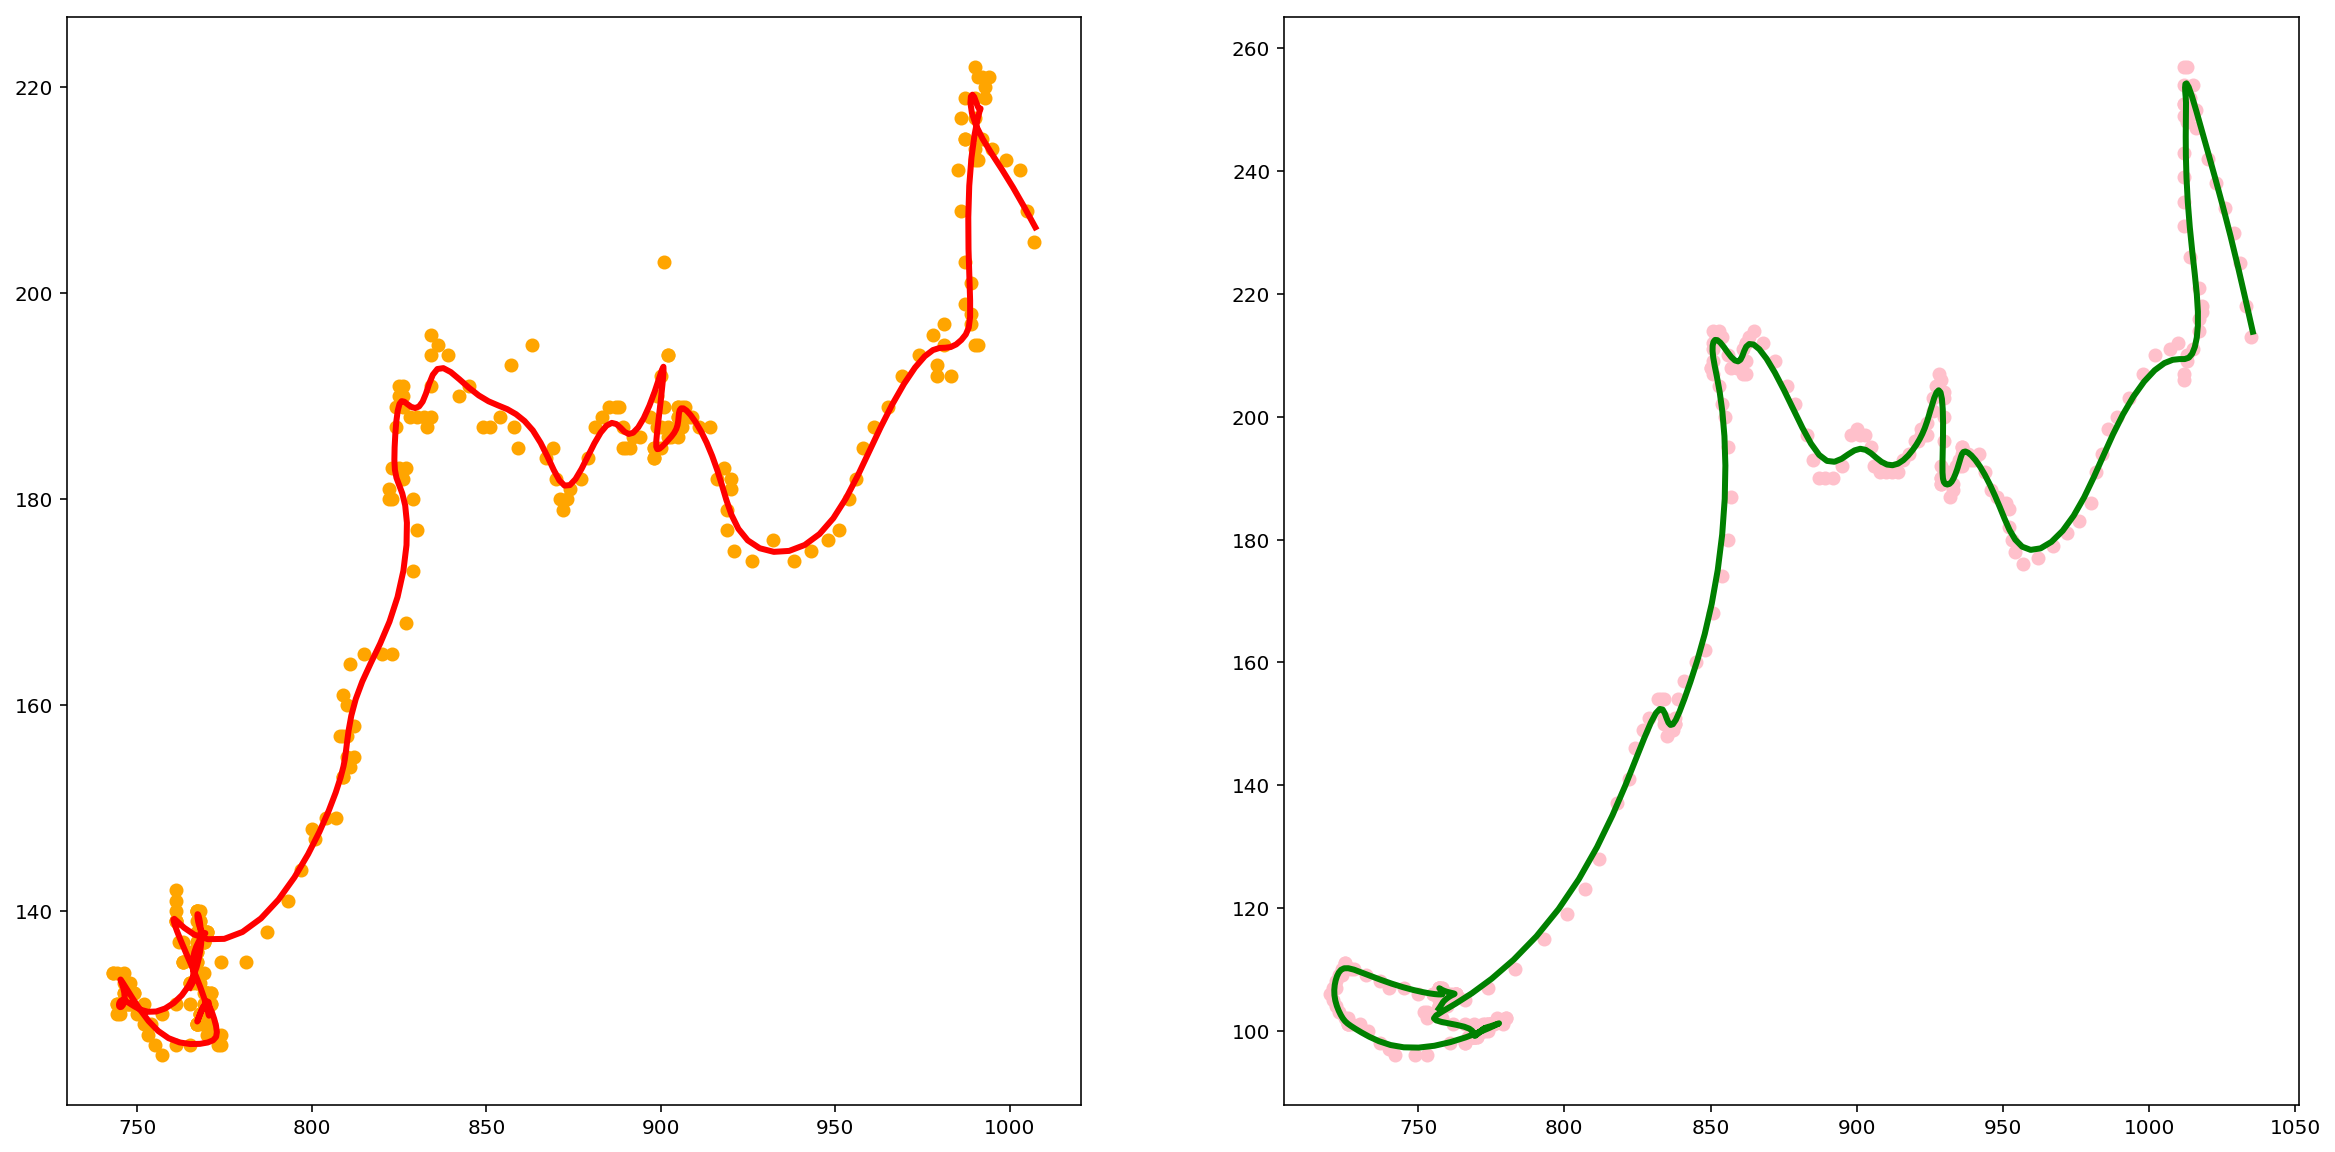

In [369]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].scatter(zs[:, 0], zs[:, 1], color='orange', zorder=-1)
axes[0].plot(xs[:, 0], xs[:, 3], color='red', linewidth=3, zorder=100);

axes[1].scatter(zs[:, 2], zs[:, 3], color='pink', zorder=-1)
axes[1].plot(xs[:, 6], xs[:, 9], color='green', linewidth=3, zorder=100);

In [370]:
n_time = 10000

zs = np.concatenate((red_centroid_over_time[:n_time], green_centroid_over_time[:n_time]), axis=1)
xs, cov = kalman_filter2(zs, F, H, Q, R, init_x.squeeze(), init_P)
xs, cov = rts_smoother(xs, cov, F, Q)

In [371]:
from tqdm import tqdm_notebook as tqdm

RGB_PINK = (234, 82, 111)
RGB_YELLOW = (253, 231, 76)
RGB_BLUE = (83, 216, 251)

RGB_RED = (255, 0, 0)
RGB_WHITE = (255, 255, 255)
RGB_PURPLE = (203, 72, 193)

video = cv2.VideoCapture('../Raw-Data/vx1_JZ1/raw/20161121/20161121_JZ1_02.1.mp4')
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
frame_size = (int(video.get(3)), int(video.get(4)))
frame_rate = video.get(5)
# n_frames = int(video.get(7))
n_frames = xs.shape[0]
out = cv2.VideoWriter('output_kalman2.avi', fourcc, frame_rate, frame_size, True)

for time_ind in tqdm(range(n_frames - 1)):
    is_grabbed, frame = video.read() 
    if is_grabbed: 
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        original_red = red_centroid_over_time[time_ind].copy()
        original_red[1] = frame_size[1] - original_red[1]

        original_green = green_centroid_over_time[time_ind].copy()
        original_green[1] = frame_size[1] - original_green[1]

        kalman_red = xs[time_ind, [0, 3]]
        kalman_red[1] = frame_size[1] - kalman_red[1]
        
        kalman_green = xs[time_ind, [6, 9]]
        kalman_green[1] = frame_size[1] - kalman_green[1]

        if np.all(~np.isnan(original_red)):
            cv2.circle(frame, tuple(original_red.astype(int)), 8, RGB_YELLOW, -1, cv2.CV_8U)
        cv2.circle(frame, tuple(kalman_red.astype(int)), 8, RGB_WHITE, -1, cv2.CV_8U)

        if np.all(~np.isnan(original_green)):
            cv2.circle(frame, tuple(original_green.astype(int)), 8, RGB_PINK, -1, cv2.CV_8U)
        cv2.circle(frame, tuple(kalman_green.astype(int)), 8, RGB_BLUE, -1, cv2.CV_8U)

        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame)
    else:
        break
        

video.release()
out.release()
cv2.destroyAllWindows()

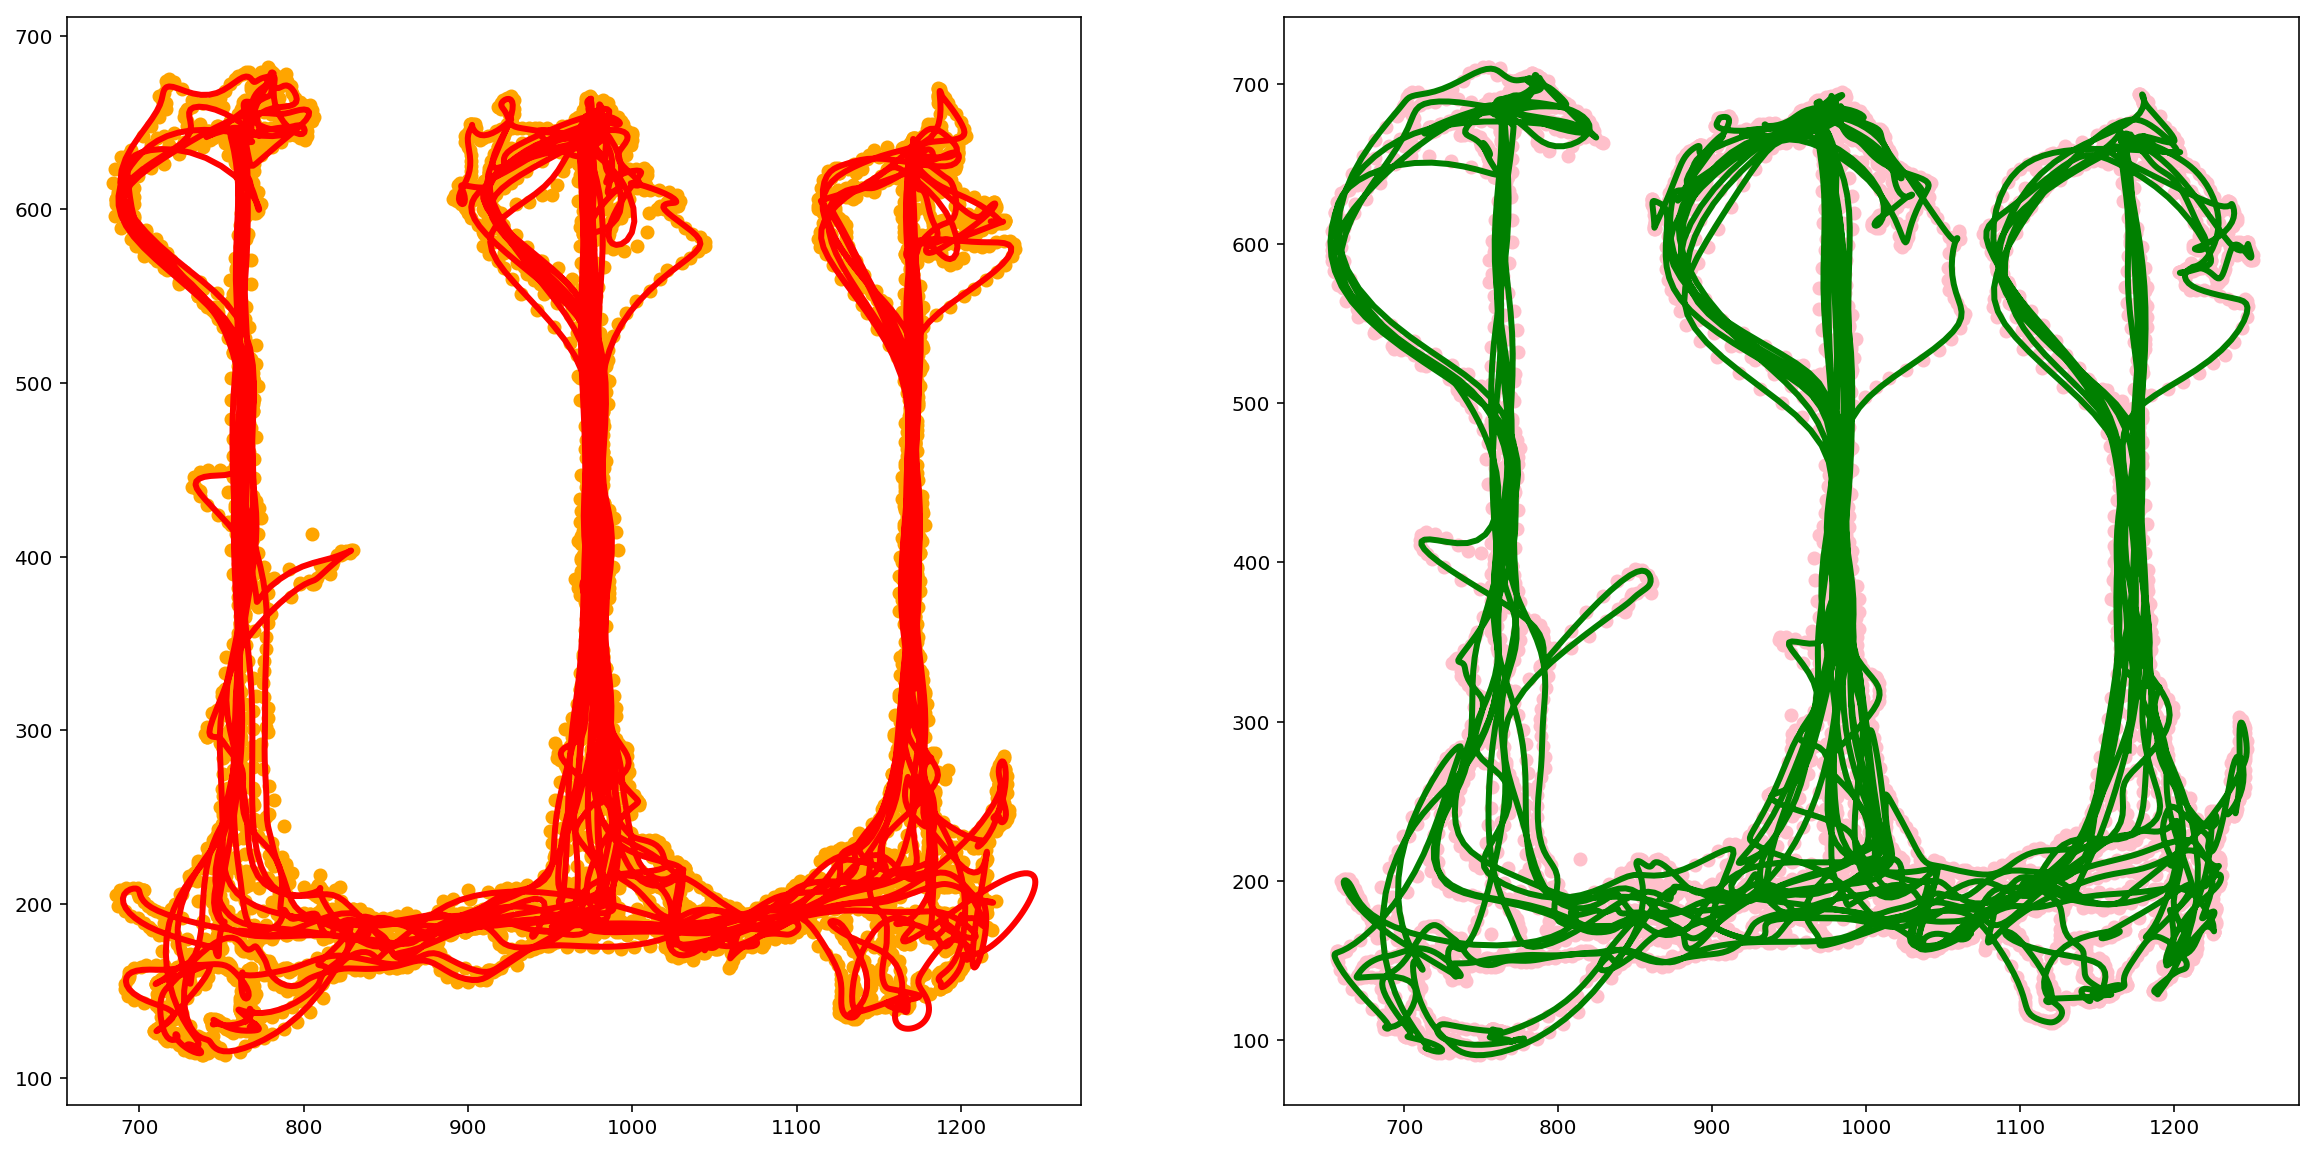

In [372]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].scatter(zs[:, 0], zs[:, 1], color='orange', zorder=-1)
axes[0].plot(xs[:, 0], xs[:, 3], color='red', linewidth=3, zorder=100);

axes[1].scatter(zs[:, 2], zs[:, 3], color='pink', zorder=-1)
axes[1].plot(xs[:, 6], xs[:, 9], color='green', linewidth=3, zorder=100);

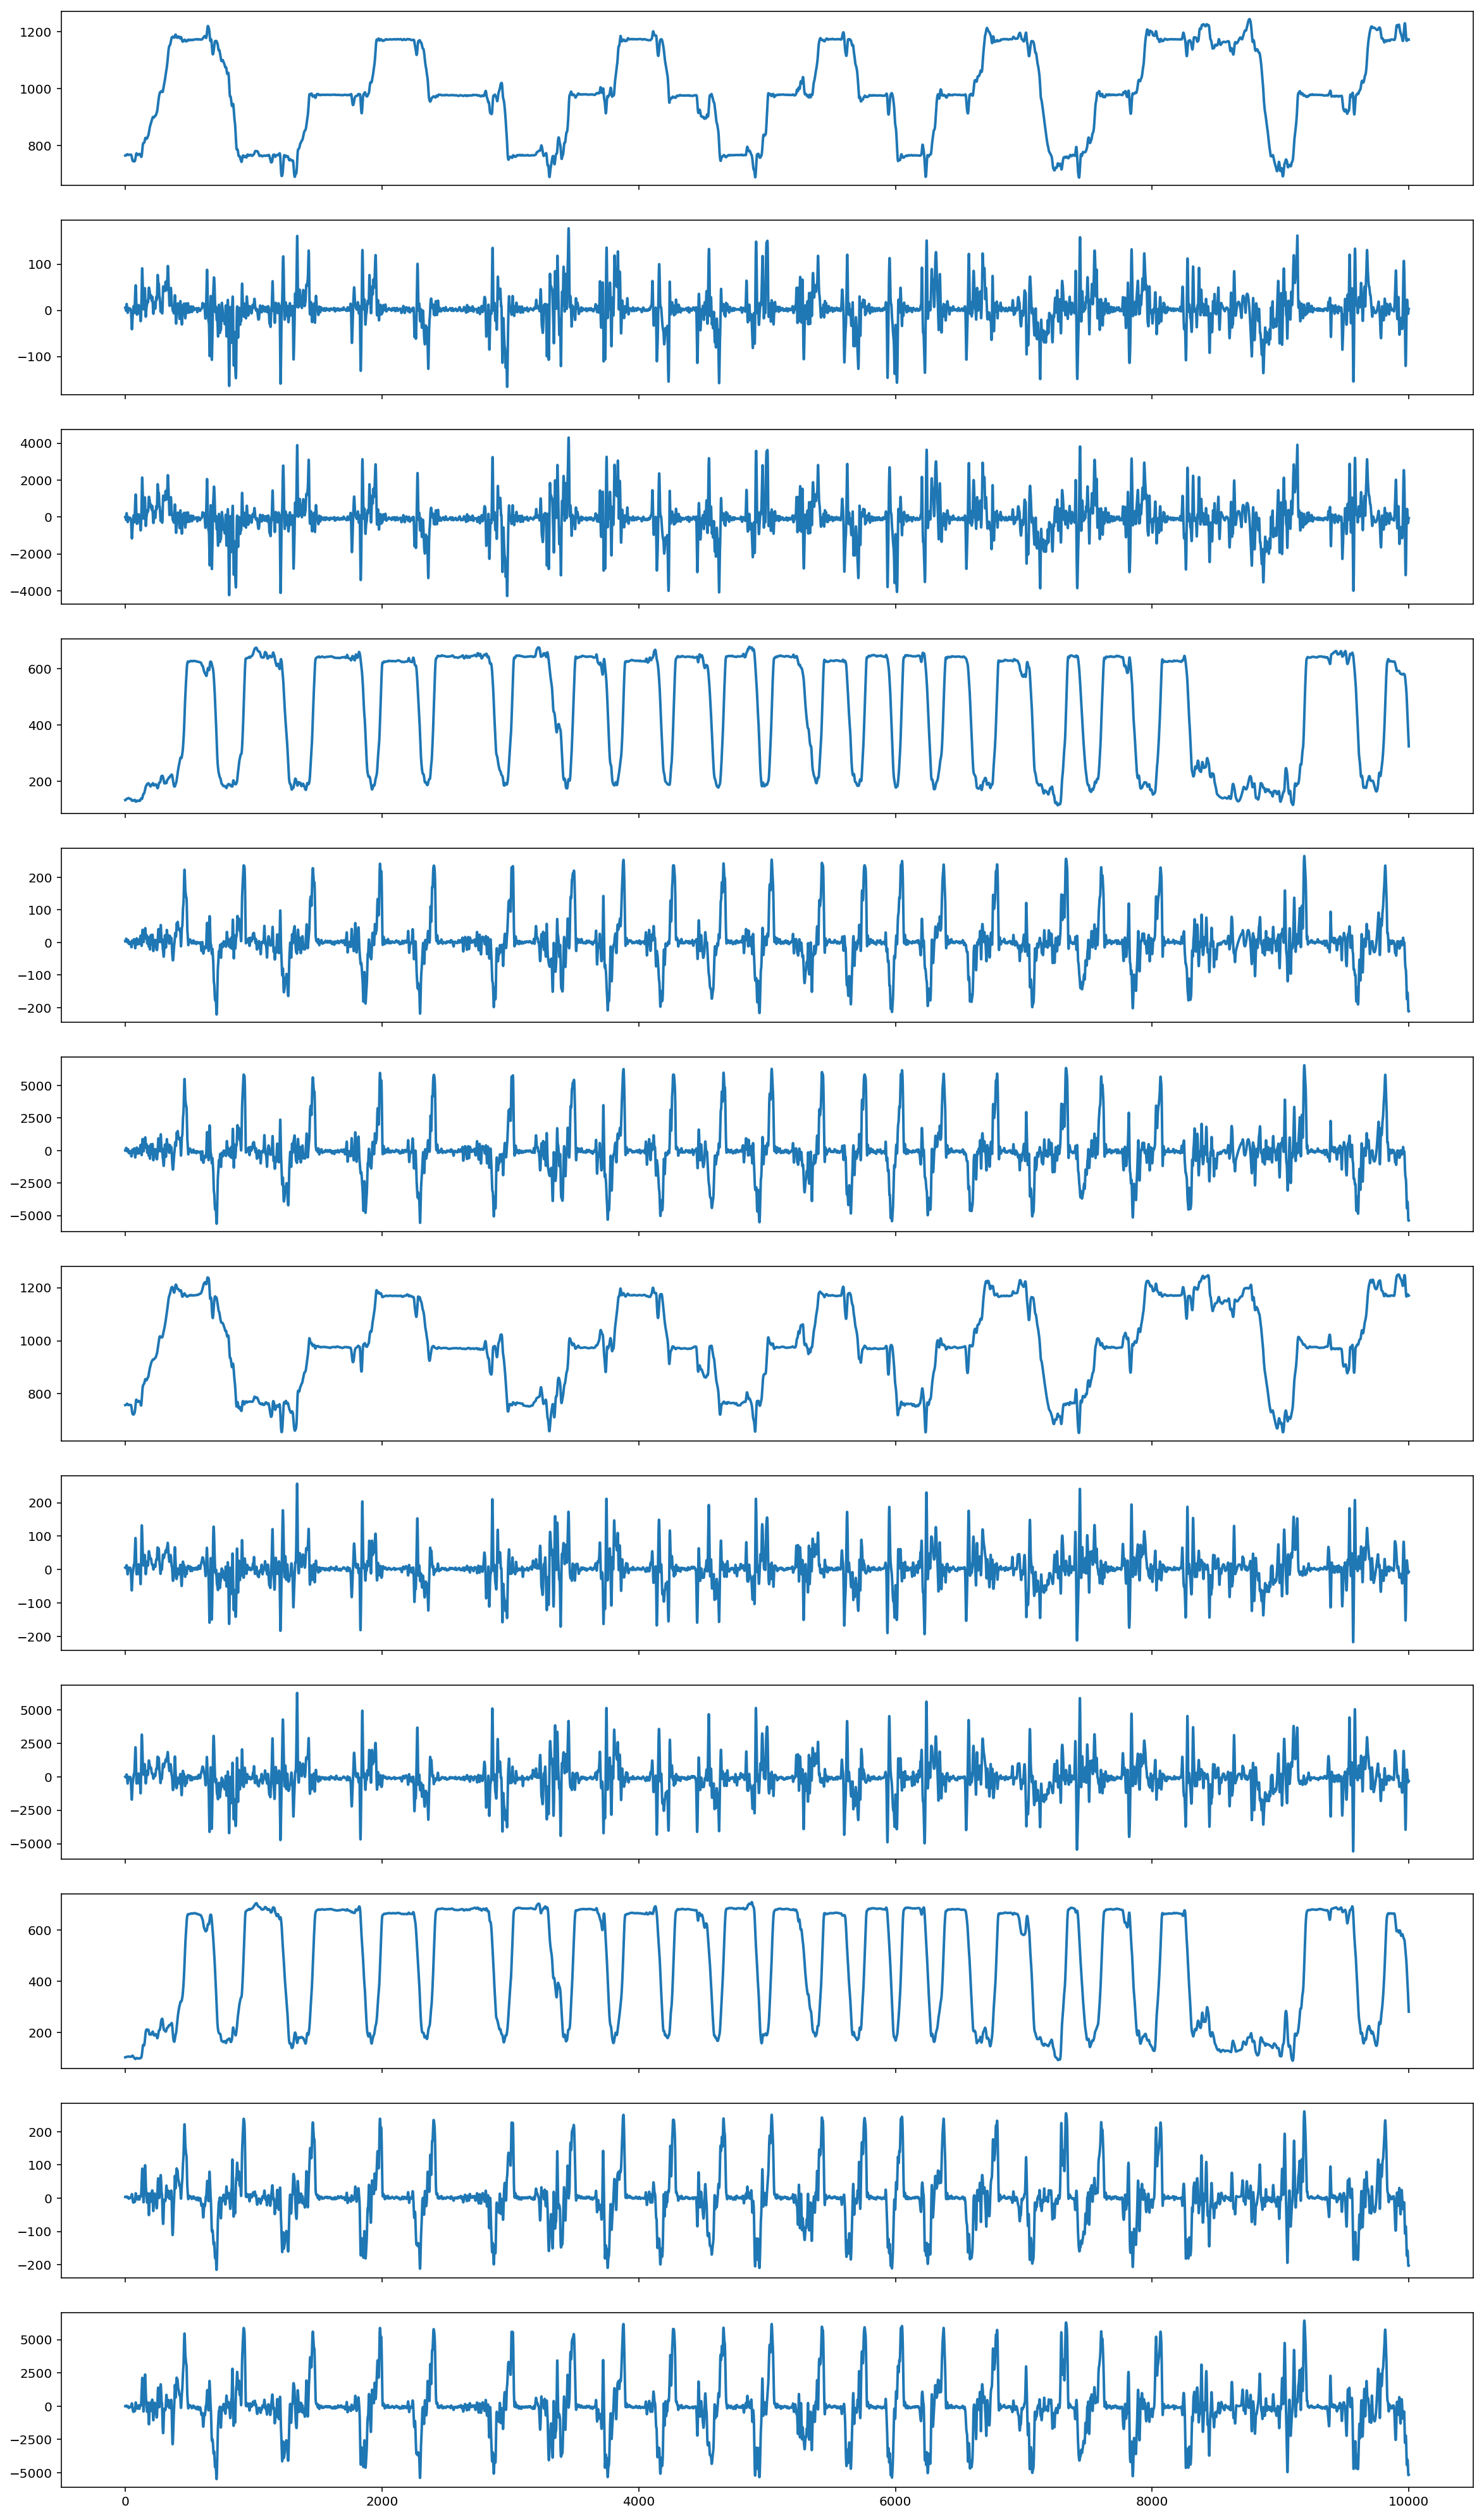

In [373]:
n_states = xs.shape[1]

fig, axes = plt.subplots(n_states, 1, figsize=(20, 3 * n_states), sharex=True);

for ind, ax in enumerate(axes.flat):
    ax.plot(np.arange(xs.shape[0]), xs[:, ind], linewidth=2, zorder=100);

In [412]:
import datetime
str(datetime.timedelta(seconds=(n_time - 1285) / frame_rate))

'0:05:48.800000'

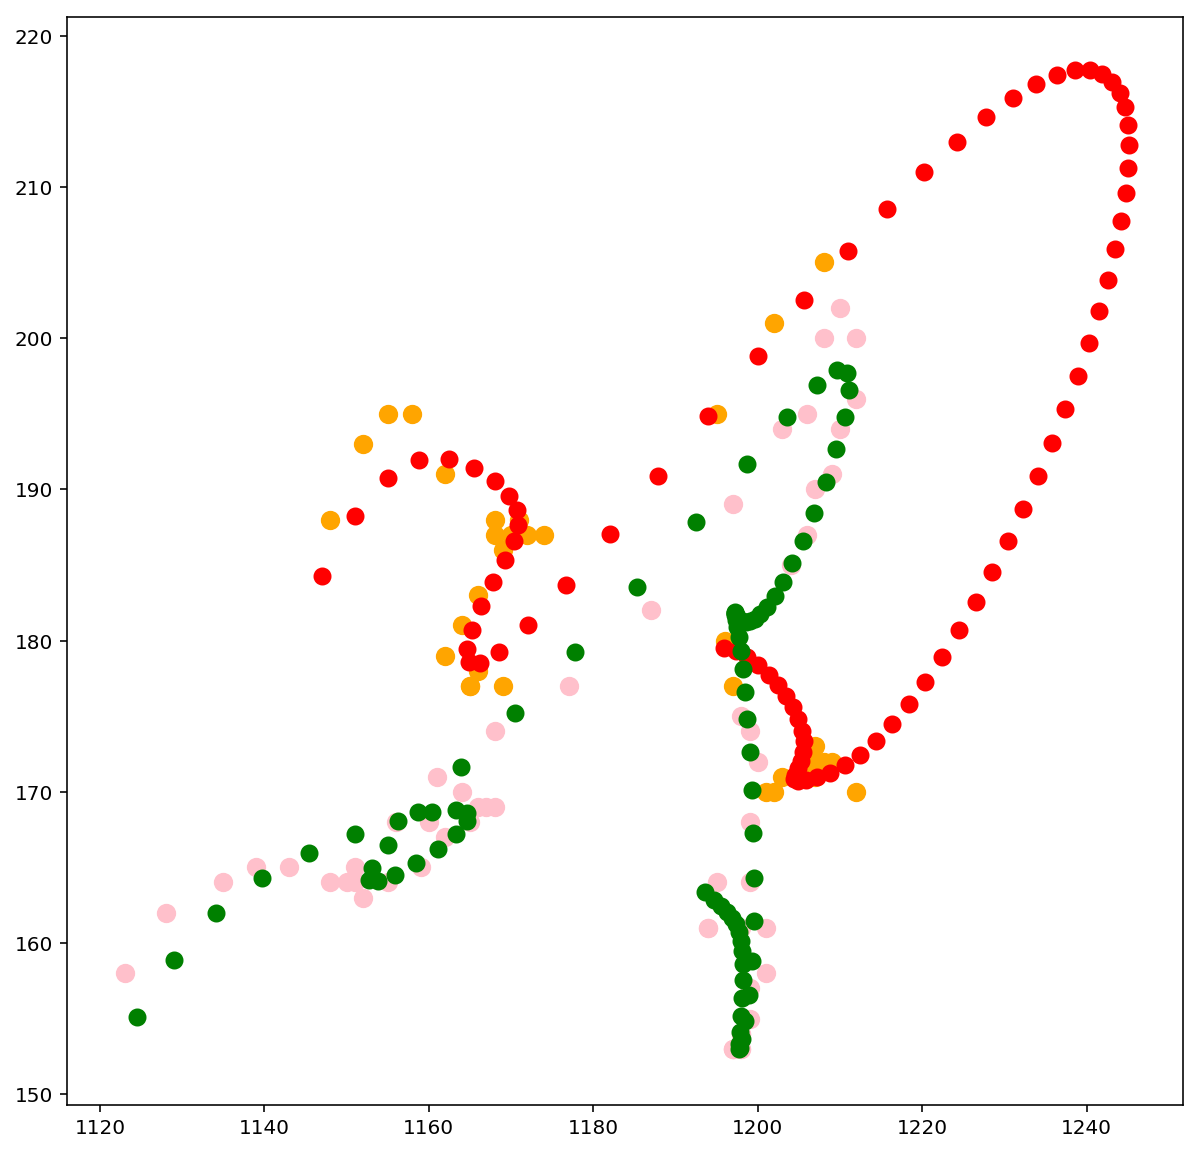

In [437]:
plt.figure(figsize=(10, 10))

t = slice(8715, 8800)

plt.scatter(zs[t, 0], zs[t, 1], color='orange', zorder=-1, s=75)
plt.scatter(xs[t, 0], xs[t, 3], color='red', linewidth=3, zorder=100);

plt.scatter(zs[t, 2], zs[t, 3], color='pink', zorder=-1, s=75)
plt.scatter(xs[t, 6], xs[t, 9], color='green', linewidth=3, zorder=100);

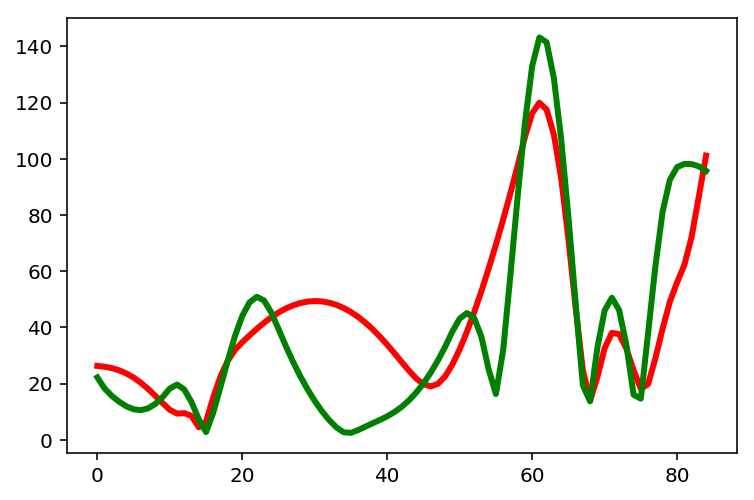

In [431]:
plt.plot(np.sqrt(xs[t, 1] ** 2 + xs[t, 4] ** 2), color='red', linewidth=3, zorder=100);
plt.plot(np.sqrt(xs[t, 7] ** 2 + xs[t, 10] ** 2), color='green', linewidth=3, zorder=100);

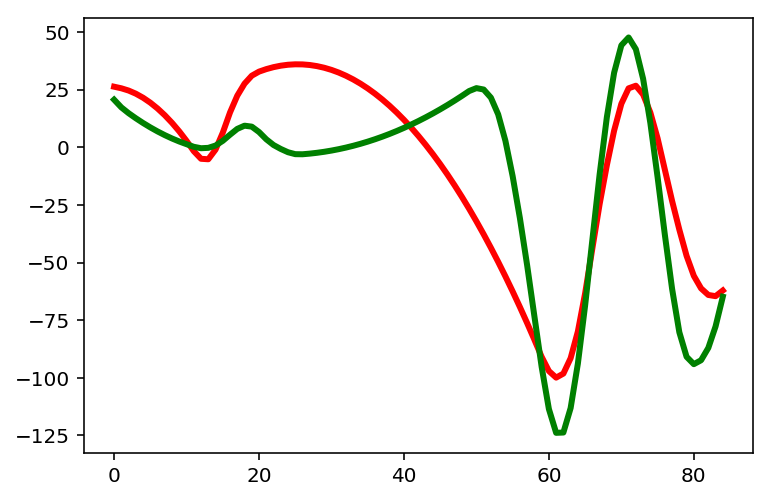

In [436]:
plt.plot(xs[t, 1], color='red', linewidth=3, zorder=100);
plt.plot(xs[t, 7], color='green', linewidth=3, zorder=100);

In [468]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import scipy.linalg

n_time = 300

zs = np.concatenate((red_centroid_over_time[:n_time], green_centroid_over_time[:n_time]), axis=1)
dt = 1 / frame_rate
q = Q_discrete_white_noise(dim=3, dt=dt, var=5)
Q = scipy.linalg.block_diag(q, q)

v = dt
a = 0.5 * dt**2
f = np.array([[1, v, a,],
              [0, 1, 0],
              [0, 0, 1]])
F = scipy.linalg.block_diag(f, f)
F

h = np.array([1, 0, 0])
H = np.concatenate((scipy.linalg.block_diag(h, h), scipy.linalg.block_diag(h, h)))

# Observation covariance
R = np.diag([1, 1, 1, 1]) * 1E-4

init_x = np.array([[(zs[0, 0] + zs[0, 2]) / 2, 0, 0, (zs[0, 1] + zs[0, 3]) / 2, 0, 0]]).T
init_P = np.diag([1, 250, 6000, 1, 250, 6000])

kalman = KalmanFilter(dim_x=6, dim_z=4)

kalman.x_prior = init_x   # state (x and dx)
kalman.P_prior = init_P   # covariance matrix

kalman.F = F    # state transition
kalman.H = H    # Measurement function

kalman.R = R    # state uncertainty
kalman.Q = Q    # process uncertainty

In [469]:
# filter data with Kalman filter, than run smoother on it
mu, cov, _, _ = kalman.batch_filter(zs)
M, P, C, _ = kalman.rts_smoother(mu, cov)

xs, cov = kalman_filter2(zs, F, H, Q, R, init_x.squeeze(), init_P)
xs, cov = rts_smoother(xs, cov, F, Q)

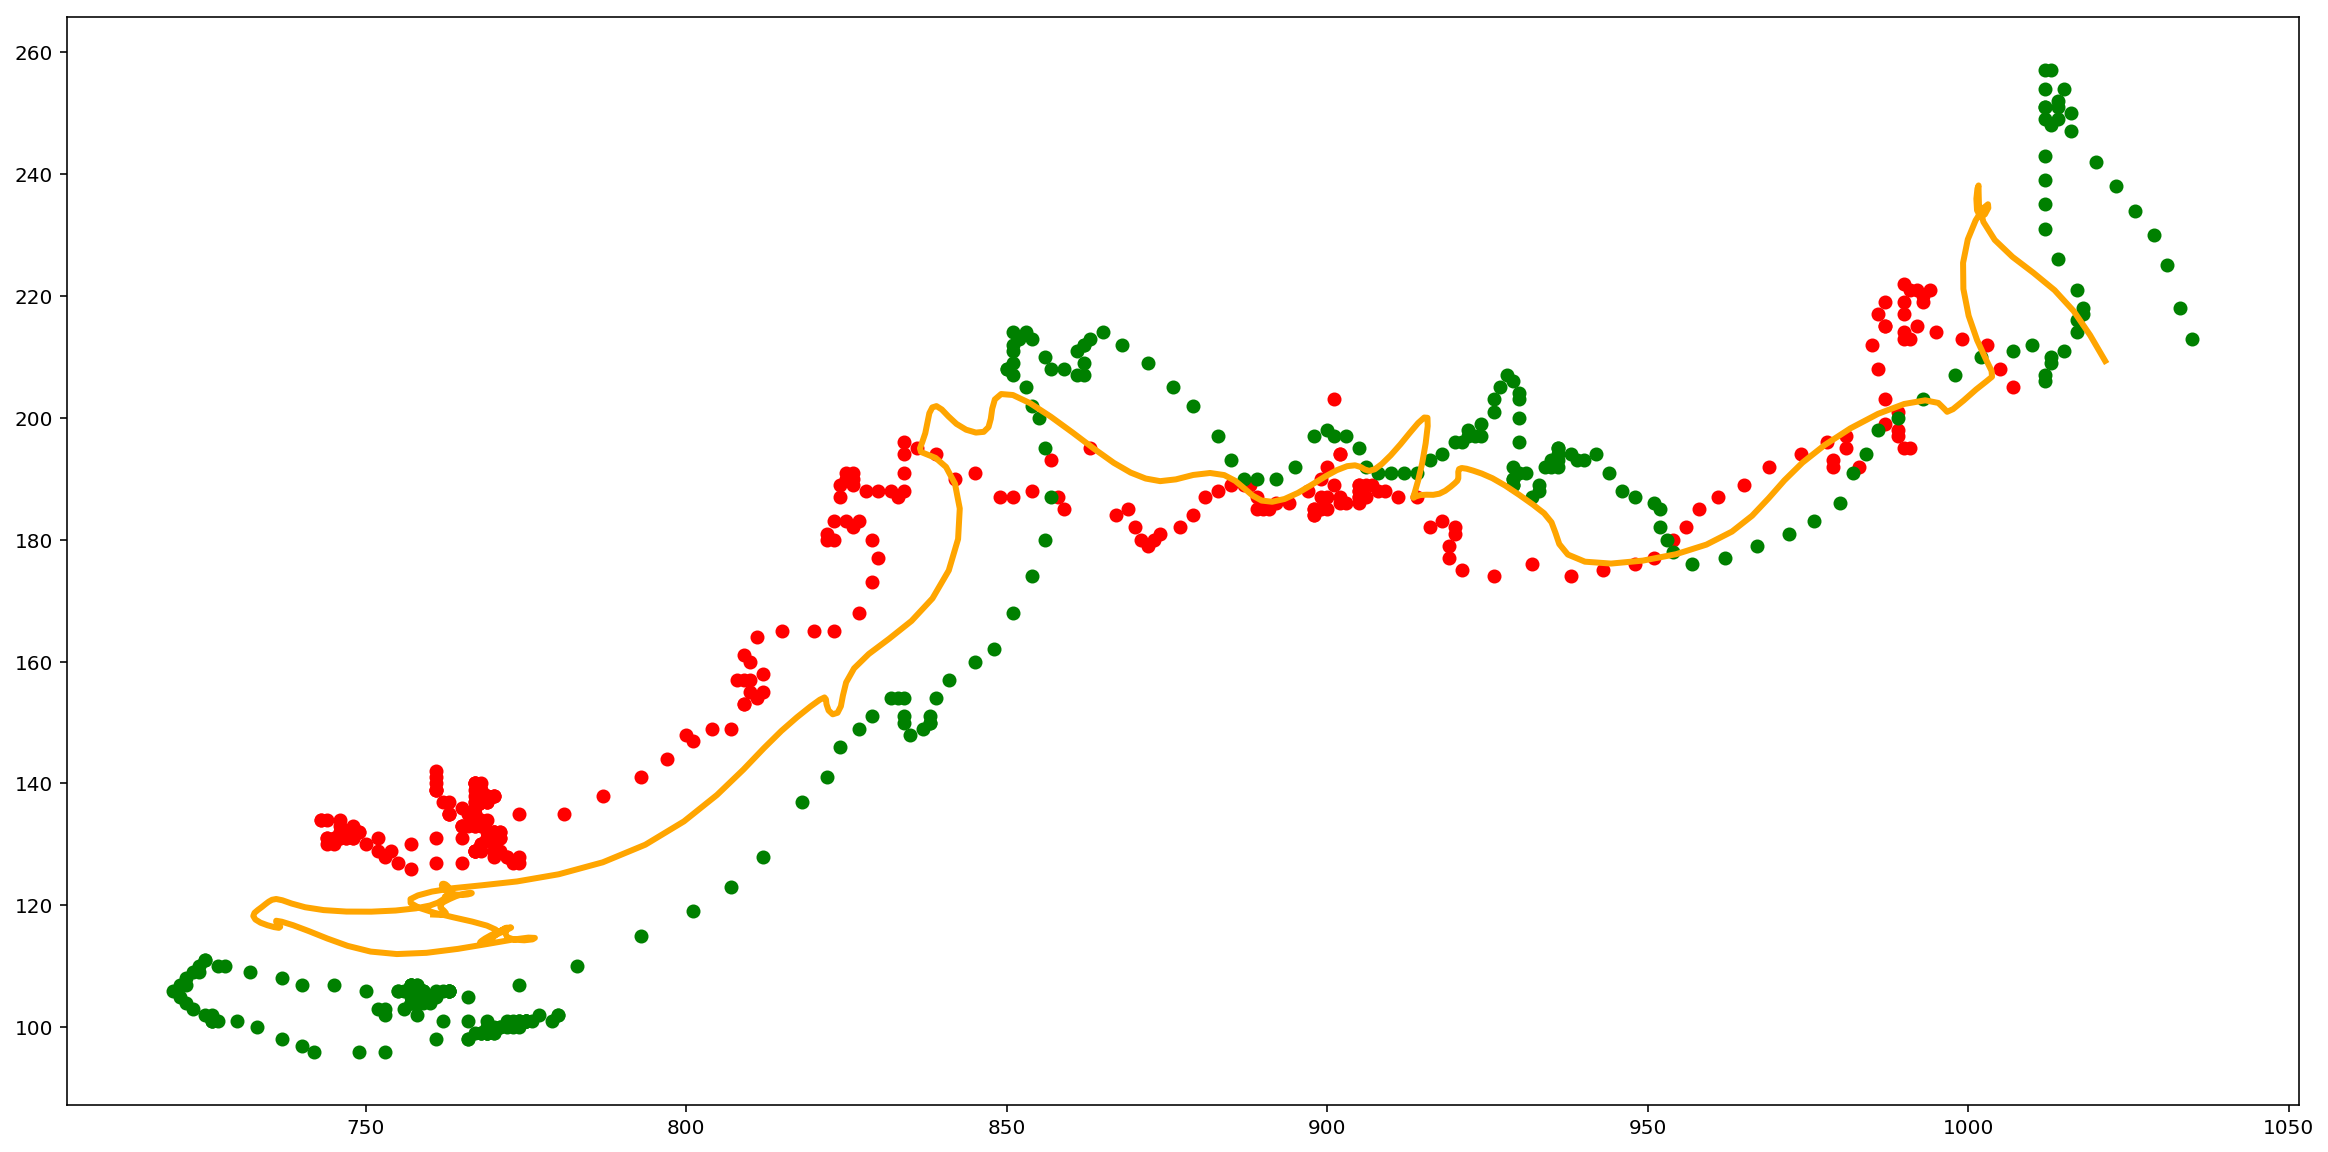

In [470]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))

axes.scatter(zs[:, 0], zs[:, 1], color='red', zorder=-1)
axes.scatter(zs[:, 2], zs[:, 3], color='green', zorder=-1)
axes.plot(xs[:, 0], xs[:, 3], color='orange', linewidth=3, zorder=100);


In [497]:
n_time = 20000

zs = np.concatenate((red_centroid_over_time[:n_time], green_centroid_over_time[:n_time]), axis=1)
xs, cov = kalman_filter2(zs, F, H, Q, R, init_x.squeeze(), init_P)
xs, cov = rts_smoother(xs, cov, F, Q)

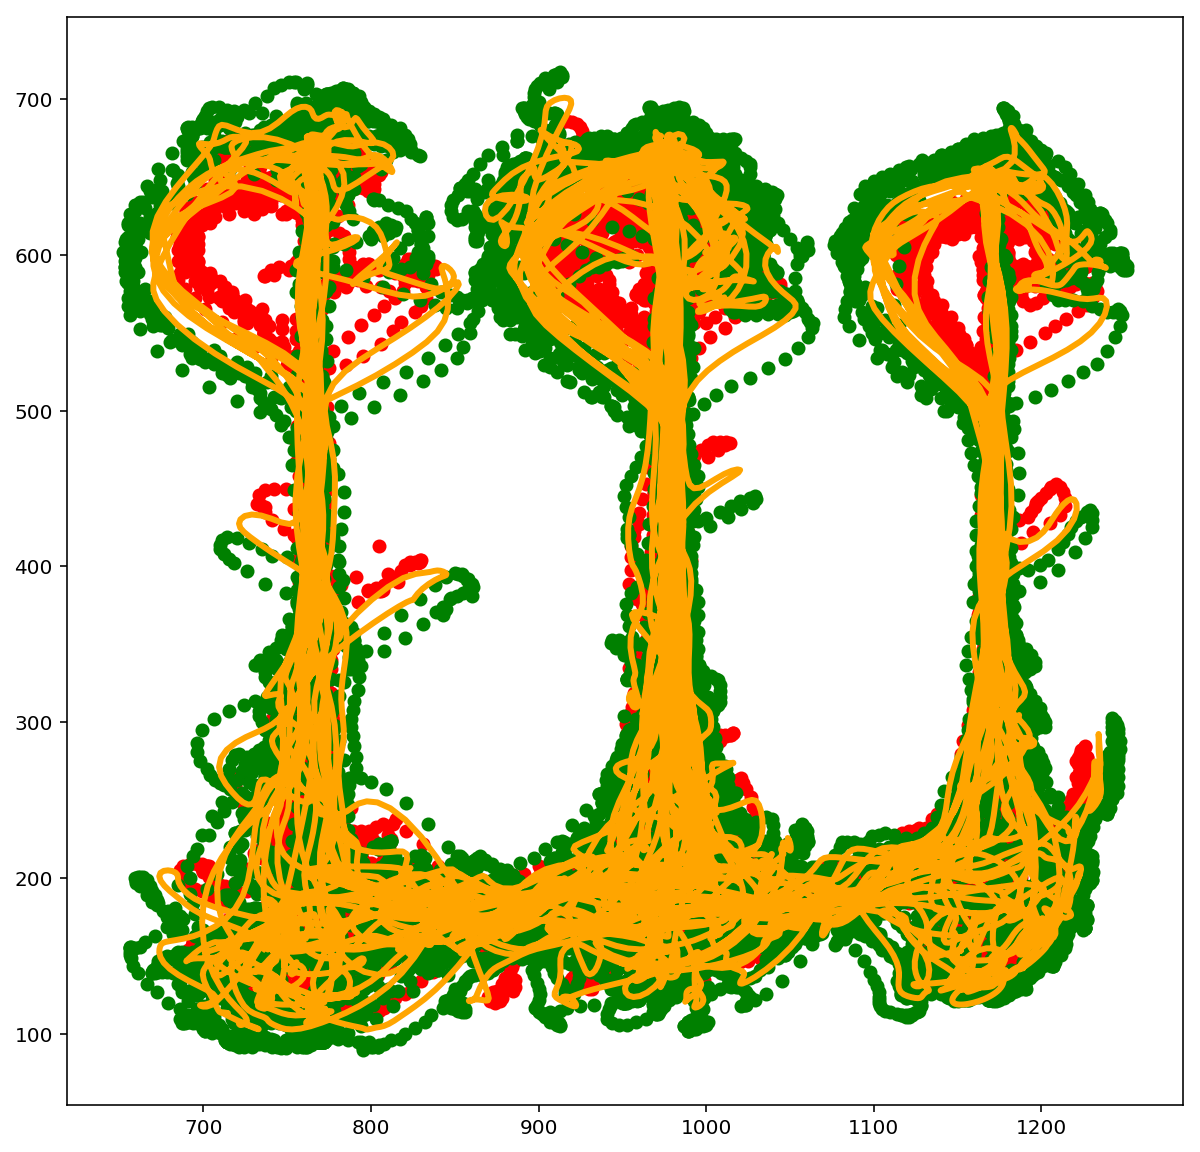

In [498]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

axes.scatter(zs[:, 0], zs[:, 1], color='red', zorder=-1)
axes.scatter(zs[:, 2], zs[:, 3], color='green', zorder=-1)
axes.plot(xs[:, 0], xs[:, 3], color='orange', linewidth=3, zorder=100);

In [499]:
from tqdm import tqdm_notebook as tqdm

RGB_PINK = (234, 82, 111)
RGB_YELLOW = (253, 231, 76)
RGB_BLUE = (83, 216, 251)

RGB_RED = (255, 0, 0)
RGB_WHITE = (255, 255, 255)
RGB_PURPLE = (203, 72, 193)

video = cv2.VideoCapture('../Raw-Data/vx1_JZ1/raw/20161121/20161121_JZ1_02.1.mp4')
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
frame_size = (int(video.get(3)), int(video.get(4)))
frame_rate = video.get(5)
# n_frames = int(video.get(7))
n_frames = xs.shape[0]
out = cv2.VideoWriter('output_kalman3.avi', fourcc, frame_rate, frame_size, True)

for time_ind in tqdm(range(n_frames - 1)):
    is_grabbed, frame = video.read() 
    if is_grabbed: 
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        original_red = red_centroid_over_time[time_ind].copy()
        original_red[1] = frame_size[1] - original_red[1]

        original_green = green_centroid_over_time[time_ind].copy()
        original_green[1] = frame_size[1] - original_green[1]

        kalman = xs[time_ind, [0, 3]]
        kalman[1] = frame_size[1] - kalman[1]

        if np.all(~np.isnan(original_red)):
            cv2.circle(frame, tuple(original_red.astype(int)), 8, RGB_YELLOW, -1, cv2.CV_8U)

        if np.all(~np.isnan(original_green)):
            cv2.circle(frame, tuple(original_green.astype(int)), 8, RGB_PINK, -1, cv2.CV_8U)
            
        cv2.circle(frame, tuple(kalman.astype(int)), 8, RGB_WHITE, -1, cv2.CV_8U)
#         cv2.ellipse(frame, tuple(kalman.astype(int)), )
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame)
    else:
        break
        

video.release()
out.release()
cv2.destroyAllWindows()

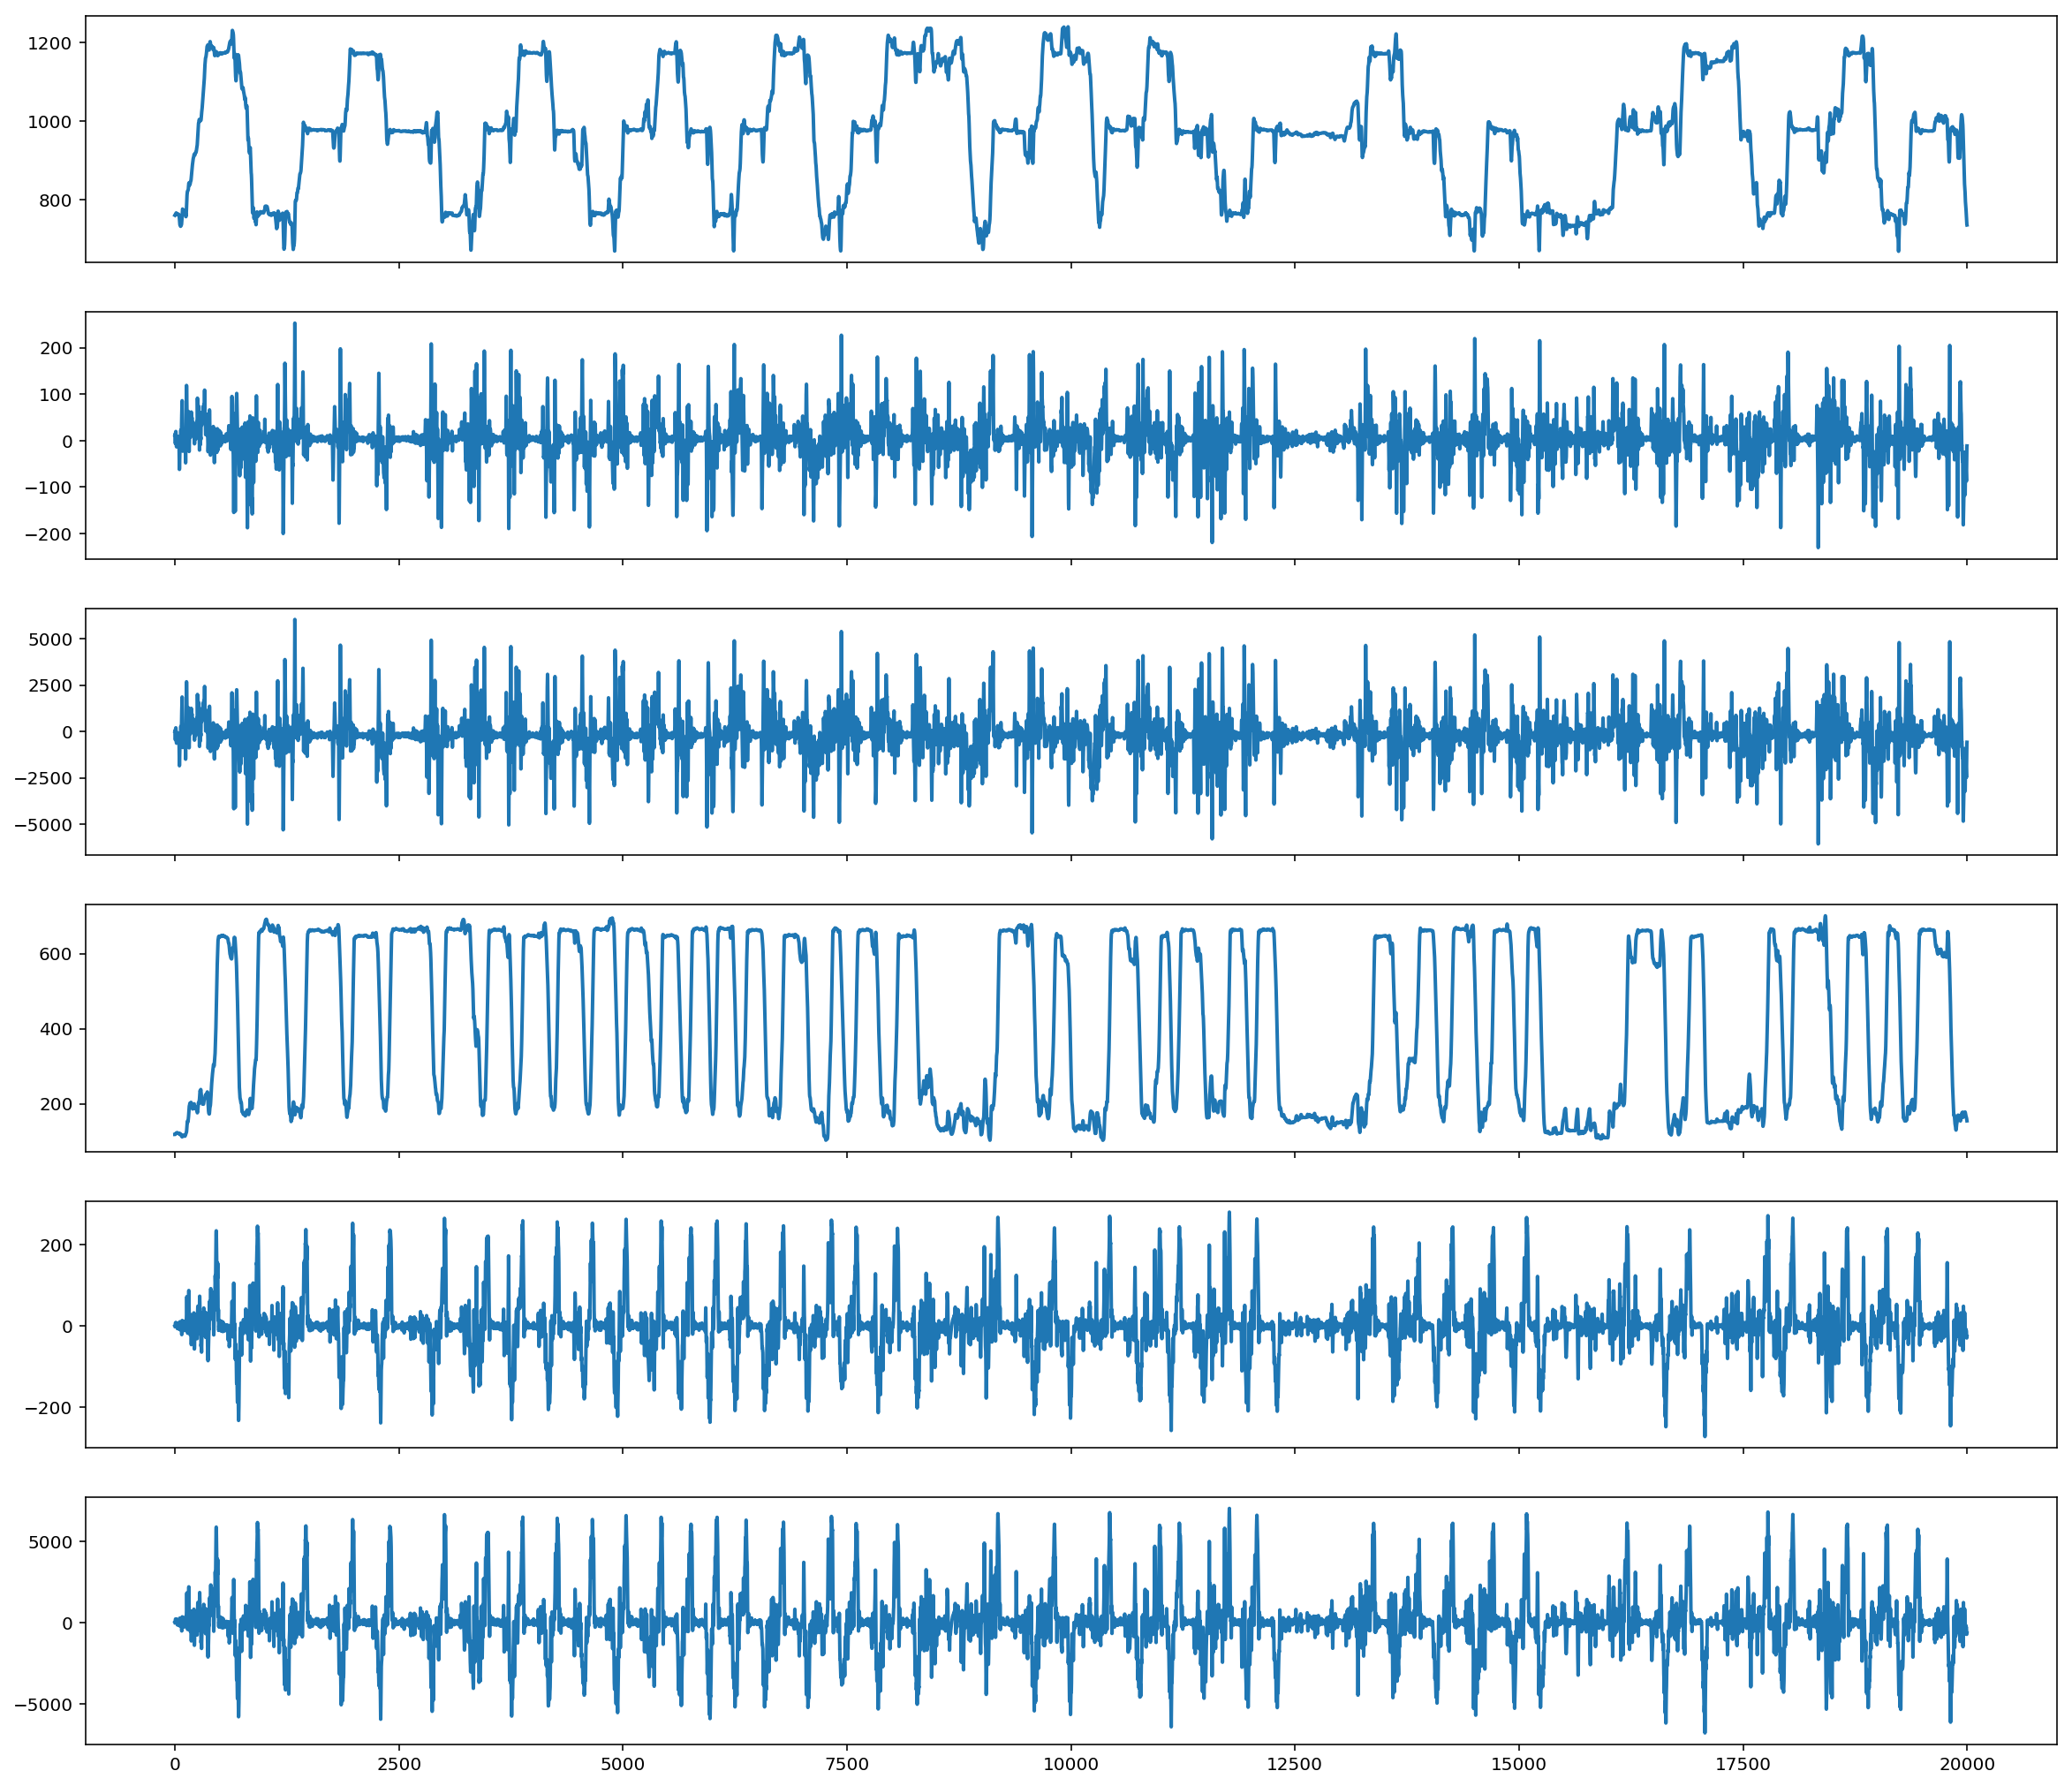

In [500]:
n_states = xs.shape[1]

fig, axes = plt.subplots(n_states, 1, figsize=(20, 3 * n_states), sharex=True);

for ind, ax in enumerate(axes.flat):
    ax.plot(np.arange(xs.shape[0]), xs[:, ind], linewidth=2, zorder=100);